# Code for "Estimating Heterogeneous Agent Models with Neural Networks"
by Hanno Kase, Leonardo Melosi and Matthias Rottner

This code implements the three-equation New Keynesian model (the first proof of concept in the paper) using our neural network method.

The current version of the paper can be found [here](https://matthias-rottner.github.io/Files/KMR_NeuralNetwork_Hank.pdf),
and the code repository is available [here](https://github.com/tseep/estimating-hank-nn)

*Note that we have changed some settings, e.g., the number of iterations, to ensure that the code runs fast in most environments.*

___

The model is a **three-equation New Keynesian model** with a single shock, specifically a Total Factor Productivity (TFP) shock. The model is log-linearized around its unique steady-state equilibrium, resulting in the following equations:

\begin{align}
	&	\hat{X}_t = E_t \hat{X}_{t+1} - \sigma^{-1}\left( \phi_{\Pi}\hat{\Pi}_t+ \phi_Y \hat{X}_{t} - E_t \hat{\Pi}_{t+1} - \hat{R}_t^\ast\right), \\
	&	\hat{\Pi}_t = \kappa \hat{X}_t + \beta E_t \hat{\Pi}_{t+1}, \\
  &	\hat{R}_t^\ast = \rho_A \hat{R}_{t-1}^\ast + \sigma (\rho_A-1)\omega {\sigma_{A}} \epsilon_t^A,
\end{align}

where output is defined as $\hat{Y}_t=(Y_t-Y)/Y$,  inflation as $\hat{\Pi}_t = \Pi_t-\Pi$, and $\hat{R}_t^\ast$ is the natural rate of interest, which follows an exogenous process that is derived from the TFP process.

## Configuration
To load the neural network solution for the model set `load_model = True`. 

To load the neural network particle filter solution set `load_pf = True`.

If set to `False`, the model and particle filter will be trained from scratch.

In [1]:
load_model = True
load_pf = True

### Google Colab notebook setup


In [ ]:
import os
from google.colab import userdata

# Is the repo public?
public = True

# Configure git
if not public:
    # Load the authentication token if the repository is private
    os.environ['GIT_AUTH'] = userdata.get('colab')
os.environ['GIT_USERNAME'] = 'tseep'
os.environ['GIT_REPO'] = 'estimating-hank-nn'
repo_dir = os.environ['GIT_REPO']

# If the repository exists, pull the latest changes. Otherwise, clone the repository.
if os.path.exists(repo_dir):
    %cd $repo_dir
    !git pull
    %cd ..
elif not public:
    !git clone https://{os.environ['GIT_AUTH']}@github.com/{os.environ['GIT_USERNAME']}/{os.environ['GIT_REPO']}.git
else:
    !git clone https://github.com/{os.environ['GIT_USERNAME']}/{os.environ['GIT_REPO']}.git

# Copy the save folder to current location
!cp -R './estimating-hank-nn/examples/save/' './save'

# Install estimating_hank_nn package
! pip install ./estimating-hank-nn/dist/*.whl

Cloning into 'estimating-hank-nn'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 158 (delta 81), reused 138 (delta 62), pack-reused 0
Receiving objects: 100% (158/158), 16.26 MiB | 20.69 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Processing ./estimating-hank-nn/dist/estimating_hank_nn-0.0.1-py3-none-any.whl


## Load packages

### Required packages specific to our code
*Note that it can take a while to install the estimating_hank_nn package.*

In [ ]:
import importlib.metadata
import subprocess

REQUIRED_PACKAGES = {
    "estimating_hank_nn": "https://github.com/tseep/estimating_hank_nn.git",
}

for package, url in REQUIRED_PACKAGES.items():
    try:
        dist = importlib.metadata.distribution(package)
        print("{} ({}) is installed".format(dist.metadata['Name'], dist.version))
    except importlib.metadata.PackageNotFoundError:
        print("{} is NOT installed. Installing now...".format(package))
        if url:
            subprocess.check_call(["pip", "install", "git+" + url])
        else:
            subprocess.check_call(["pip", "install", package])

estimating-hank-nn (0.0.1) is installed


### Load packages

In [ ]:
import torch
import math
from pathlib import Path
from copy import deepcopy
import pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator, NullLocator
import numpy as np
from tqdm import trange

# Style for plots
from estimating_hank_nn.plot_helpers import set_rc_params, style_fig_ax, save_figure

# Structures to hold the elements of the model
from estimating_hank_nn.structures import Parameters, State, Ranges, Shocks

# Neural network layers
from estimating_hank_nn.networks import NormalizeLayer

# Helper funcitons
from estimating_hank_nn.helpers import ergodic_sigma

## Extended Model Solution with our Neural Network Approach
Outline:
1. **Parameters** - set the parameter values and bounds of the model.
2. **Class for the simple 3 equation NK model** - creat a class for the model that has methods to simulate the model, calculate the residuals, calculate the loss, and train the model.
3. **Create the model and train it** - create the model object and train the NN to solve the model.

### Parameters

In [ ]:
NK_par = {
    "beta": 0.97,
    "sigma": 2.0,
    "eta": 1.125,
    "phi": 0.7,
    "phipi": 1.875,
    "phiy": 0.25,
    "rho_a": 0.875,
    "sigma_a": 0.06,
}

NK_range = {
    "beta": torch.distributions.Uniform(0.95, 0.99),
    "sigma": torch.distributions.Uniform(1.0, 3.0),
    "eta": torch.distributions.Uniform(0.25, 2.0),
    "phi": torch.distributions.Uniform(0.5, 0.9),
    "phipi": torch.distributions.Uniform(1.25, 2.5),
    "phiy": torch.distributions.Uniform(0.0, 0.5),
    "rho_a": torch.distributions.Uniform(0.8, 0.95),
    "sigma_a": torch.distributions.Uniform(0.02, 0.1),
}

# Distribution for the shock process innovations
shock_dist = {
    "zeta": torch.distributions.Normal(0.0, 1.0),
}

### Class for the simple 3 equation NK model

To give an overview, the `NKModel` class has the following methods:
* Convenience methods: 
  * `to` - move the model to a device,
  * `save` - save the model object,
  * `load` - load the model object,
  * `load_attributes` - load the attributes of the model object.
* Neural network methods:
  * `make_network` - create the neural network (MLP),
* Methods to define the economic model:
  * `steady_state` - calculate the steady state of the model,
  * `policy` - calculate the policy functions of the model, a wrapper around the neural network,
  * `residuals` - calculate the residuals of the model,
  * `loss` - calculate the loss of the model,
* Simulation methods:
  * `initialize_state` - initialize the state of the model,
  * `draw_parameters` - draw parameters from the parameter distribution,
  * `draw_shocks` - draw shocks from the shock distribution,
  * `sim_step` - simulate one step of the model,
  * `sim_steps` - simulate multiple steps of the model,
  * `simulate` - simulate the model for a given number of steps while also recording results.
* Training methods:
  * `train_model` - train the model,

**In short, the `residuals` method is the most important and effectively defines the economic model.**

In [ ]:
class NKModel(object):
    def __init__(self, parameters, ranges, shocks) -> None:
        self.range = Ranges(parameters, ranges)
        self.shock = Shocks(shocks)
        self.par = Parameters(parameters)
        self.par_draw = None
        self.ss = None
        self.state = None
        self.network = self.make_network()
        self.loss_dict = None
        self.training_conf = None

    def to(self, device):
        self.par.to(device)
        self.par_draw.to(device)
        self.ss.to(device)
        self.state.to(device)
        self.network.to(device)

    def save(self, path, name="model"):
        # Create directory
        Path(path).mkdir(parents=True, exist_ok=True)

        # Save NKModel object
        self.to("cpu")
        with open(f"{path}/{name}.pkl", "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, path):
        # Load the object
        with open(path, "rb") as f:
            return pickle.load(f)

    def load_attributes(self, path):
        # Load attributes
        with open(path, "rb") as f:
            load = pickle.load(f)

        # Populate attributes
        self.__dict__.update(load.__dict__)

    def make_network(self, N_states=1, N_par=None, N_outputs=2, hidden=64, layers=5, activation=torch.nn.CELU(), normalize=True):
        # Detect device
        device = self.par.values()[0].device

        # Number of parameters
        if N_par is None:
            N_par = len(self.par)
        N_inputs = N_states + N_par

        layer_list = []

        # Normalize layer
        if normalize:
            lb = torch.cat([-torch.ones(N_states, device=device), self.range.low_tensor()], dim=-1)
            ub = torch.cat([+torch.ones(N_states, device=device), self.range.high_tensor()], dim=-1)
            layer_list.append(NormalizeLayer(lb, ub))

        # First layer
        layer_list.append(torch.nn.Linear(N_inputs, hidden))
        layer_list.append(activation)

        # Middle layers
        for _ in range(1, layers):
            layer_list.append(torch.nn.Linear(hidden, hidden))
            layer_list.append(activation)

        # Last layer
        layer_list.append(torch.nn.Linear(hidden, N_outputs))

        return torch.nn.Sequential(*layer_list)

    def steady_state(self, par=None):
        if par is None:
            par = self.par_draw

        kappa = ((1 - par.phi) * (1 - par.phi * par.beta) * (par.sigma + par.eta)) / par.phi
        omega = (1 + par.eta) / (par.sigma + par.eta)

        return Parameters({"kappa": kappa, "omega": omega})

    def initialize_state(self, par=None, batch=100, multiplier=1.0, device="cpu"):
        if par is None:
            par = self.par_draw

        # Steady state
        ss = self.steady_state(par=par)

        # Ergodic standard deviation of zeta
        rho = par.rho_a
        sigma = par.sigma_a * par.sigma * (par.rho_a - 1) * ss.omega
        ergodic = ergodic_sigma(rho, sigma)

        # Draw initial value for zeta from ergodic distribution
        zeta = torch.randn((batch, 1), device=device) * ergodic * multiplier

        return State({"zeta": zeta})

    def draw_parameters(self, shape, device="cpu"):
        return self.range.sample(shape, device=device)

    def draw_shocks(self, shape, antithetic=False, device="cpu"):
        return self.shock.sample(shape, antithetic, device=device)

    def policy(self, state=None, par=None):
        if state is None:
            state = self.state
        if par is None:
            par = self.par_draw

        # Vector of states and parameters
        input_state = state.cat()
        input_par = par.cat()

        # Expand if necessary (for calculating expectations)
        if input_state.ndim > input_par.ndim:
            input_par_shape = list(input_par.shape)
            input_par_shape.insert(0, input_state.size(0))
            input_par = input_par.unsqueeze(0).expand(input_par_shape)

        # Prepare the input by concatenating states and parameters
        input = torch.cat([input_state, input_par], dim=-1)

        # Evaluate the network
        output = self.network(input)

        # Assign and scale the output
        X = output[..., 0:1] / 100
        Pi = output[..., 1:2] / 100

        return X, Pi

    @torch.no_grad()
    def step(self, e):
        par = self.par_draw
        ss = self.ss
        state = self.state

        zeta_next = par.rho_a * state.zeta + e.zeta * par.sigma_a * par.sigma * (par.rho_a - 1) * ss.omega

        return State({"zeta": zeta_next})

    def steps(self, batch, device, steps):
        for _ in range(steps):
            e = self.draw_shocks((batch, 1), device=device)
            self.state = self.step(e)

    @torch.no_grad()
    def sim_step(self, par=None):
        if par is None:
            par = self.par_draw
        R = self.state.zeta
        X, Pi = self.policy(self.state, par)
        return {"R": R, "X": X, "Pi": Pi}

    @torch.no_grad()
    def simulate(self, batch, par=None, burn=99, steps=101, device="cpu", seed=None):
        # Manual seed
        if seed is not None:
            torch.manual_seed(seed)

        # Set parameters and dimensions
        if par is None:
            self.par_draw = self.par.expand((batch, 1))
        else:
            self.par_draw = par.expand((batch, 1))

        # Change the device of the model
        self.to(device)

        # Initialize
        self.state = self.initialize_state(batch=batch, device=device)
        self.ss = self.steady_state()

        # Burn-in
        self.steps(batch=batch, device=device, steps=burn)

        # Simulate
        results = {"R": [], "X": [], "Pi": []}
        for _ in range(steps):
            out = self.sim_step()

            # Store results
            for key, value in out.items():
                results[key].append(value.squeeze(-1))

            # Update state
            e = self.draw_shocks((batch, 1), device=device)
            self.state = self.step(e)

        # Stack results
        for key, value in results.items():
            results[key] = torch.stack(value, dim=-1)

        return results

    def residuals(self, e):
        par = self.par_draw
        ss = self.ss
        state = self.state

        # Output gap and inflation period t
        X, Pi = self.policy(self.state, self.par_draw)

        # Next period state
        state_next = self.step(e)

        # Expected output gap and inflation period t+1
        X_next, Pi_next = self.policy(state_next, self.par_draw)
        EX_next = torch.mean(X_next, dim=0)
        EPi_next = torch.mean(Pi_next, dim=0)

        # Residuals
        nkpc = Pi - (ss.kappa * X + par.beta * EPi_next)
        bond_euler = X - (EX_next - 1 / par.sigma * (par.phipi * Pi + par.phiy * X - EPi_next - state.zeta))

        return torch.sum(nkpc**2), torch.sum(bond_euler**2)

    def loss(self, nkpc, bond_euler, batch, weights=[1.0, 1.0]):
        loss = weights[0] * nkpc + weights[1] * bond_euler
        return loss, {"nkpc": nkpc / batch, "bond_euler": bond_euler / batch}

    def train_model(
        self,
        iteration=10000,
        internal=1,
        steps=10,
        batch=100,
        mc=10,
        par_draw_after=100,
        lr=1e-3,
        eta_min=1e-10,
        device="cpu",
        print_after=100,
    ):
        # Save training configuration
        self.training_conf = locals().copy()

        # Print training configuration
        print("Training configuration:")
        for key, value in self.training_conf.items():
            if key != "self":
                print(f"{key}: {value}")

        # Set the network to train mode
        self.network.train()
        self.network.to(device)

        # Initialize
        self.par_draw = self.draw_parameters(shape=(batch, 1), device=device)
        self.state = self.initialize_state(batch=batch, device=device)
        self.ss = self.steady_state()

        # Starting weights for loss components
        weights = [1.0, 1.0]

        # Optimizer and scheduler
        optimizer = torch.optim.AdamW(self.network.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iteration, eta_min=eta_min)

        # Dictionary for loss
        self.loss_dict = {"iteration": [], "total": [], "nkpc": [], "bond_euler": []}

        # Progress bar
        pbar = trange(iteration)

        # Training loop
        running_loss = 0.0
        for i in pbar:
            for o in range(internal):
                optimizer.zero_grad()
                e = self.draw_shocks((mc, batch, 1), antithetic=True, device=device)
                nkpc, bond_euler = self.residuals(e)
                loss, loss_components = self.loss(nkpc, bond_euler, batch=batch, weights=weights)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), 1.0)
                optimizer.step()

                # Record loss
                if o == 0:
                    self.loss_dict["iteration"].append(i)
                    self.loss_dict["total"].append(loss.item())
                    for key, value in loss_components.items():
                        self.loss_dict[key].append(value.item())

                    # Running loss
                    running_loss += loss.item() / batch

            # Print running loss in the progress bar after 100 iterations
            if i % print_after == 0:
                pbar.set_postfix({"lr:": scheduler.get_last_lr()[0], "loss": running_loss / print_after})
                running_loss = 0.0

            # Update learning rate
            scheduler.step()

            # Draw new parameters
            if i % par_draw_after == 0:
                self.par_draw = self.draw_parameters((batch, 1), device=device)
                self.ss = self.steady_state()

            # Sample states by simulation
            self.steps(batch=batch, device=device, steps=steps)

        # Set network to evaluation mode
        self.network.eval()

### Create the model and train it

In [ ]:
# Create the model object
model = NKModel(NK_par, NK_range, shock_dist)

In [ ]:
# Train the networks (shorter training run compared to the paper)
if not load_model:
    model.train_model(iteration=50000, internal=5, steps=10, batch=100, mc=10, par_draw_after=1, device="cpu", print_after=100, lr=1e-3, eta_min=1e-10)

In [ ]:
# Save the model
if not load_model:
    model.save(path="save", name="analytical_example")

## Load the saved model
There are two options to load the model:
1. Load the model object
```python
model = NKModel.load("save/analytical_example.pkl")
```
2. Load only the attributes of the model like:
```python
model = NKModel(NK_par, NK_range, shock_dist)
model.load_attributes("save/analytical_example.pkl")
```

In [ ]:
# Load the model object
if load_model:
    model = NKModel.load("save/analytical_example.pkl")

## Figures illustrating the solution

In [ ]:
# Create a folder for figures
directory = "figures"  # Define the directory
Path(directory).mkdir(parents=True, exist_ok=True)  # Create the directory if it does not exist

# Set the style for the plots
set_rc_params()



### Figure 2 in the paper. 
*Note that the figure may deviate from the one in the paper because some settings are not exactly the same as in the paper. We made these adjustments to ensure a fast runtime in different computational environments.*

In [ ]:
def plot_avg_loss(loss_dict, ylim=[1e-10, 1e-4], ma=1000, legend=None, fig=None, ax=None):
    # Create figure and axes if not provided
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10.0 / 1.55, 5.0 / 1.55))

    # Calculate mean over all loss components (except iteration and total)
    total_avg = np.zeros_like(np.array(loss_dict["total"]))
    for key, value in loss_dict.items():
        if key not in ["iteration", "total"]:
            total_avg += np.array(value)
    total_avg /= len(loss_dict) - 2

    # Add total_avg to loss_dict
    loss_dict["total_avg"] = total_avg.tolist()

    # Moving average over loss
    tmp_dict = {key: np.convolve(value, np.ones(ma), "valid") / ma for key, value in loss_dict.items()}

    # Plot losses, including legend
    ax.plot(tmp_dict["iteration"], tmp_dict["total_avg"], label=legend, color="blue")
    ax.set_title("Total loss during the training")
    ax.set_yscale("log")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_ylabel("Mean squared error")
    ax.set_xlabel("Iteration")

    # Adjust layout
    plt.tight_layout()

    # Adjust style
    fig, ax = style_fig_ax(fig, ax)

    return fig, ax

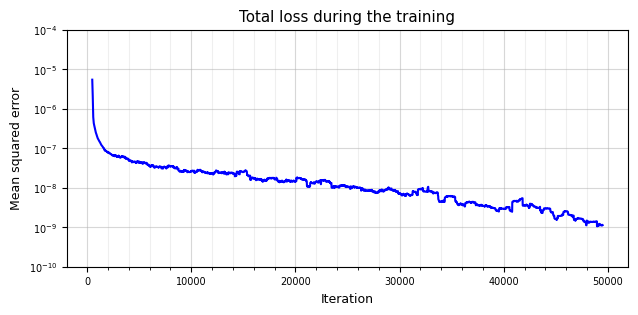

In [ ]:
fig_avg_loss, _ = plot_avg_loss(model.loss_dict, ma=1000)

In [ ]:
save_figure(fig_avg_loss, f"{directory}/model_loss")

### Additional figure.
Figure shows the average loss as well as the loss of the different residual equations.

In [ ]:
def plot_loss(loss_dict, ylim=None, ma=1000, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(10.0 / 1.55, 5.0 / 1.55))

    # Calculate mean over all loss components (except iteration and total)
    total_avg = np.zeros_like(np.array(loss_dict["total"]))
    for key, value in loss_dict.items():
        if key not in ["iteration", "total"]:
            total_avg += np.array(value)
    total_avg /= len(loss_dict) - 2

    # Add total_avg to loss_dict
    loss_dict["total_avg"] = total_avg.tolist()

    # Moving average over loss
    tmp_dict = {key: np.convolve(value, np.ones(ma), "valid") / ma for key, value in loss_dict.items()}

    # Plot losses, including legend
    ax[0].plot(tmp_dict["iteration"], tmp_dict["total_avg"])
    ax[0].set_title("Average loss")
    ax[0].set_yscale("log")
    if ylim is not None:
        ax[0].set_ylim(ylim)
    else:
        ylim = ax[0].get_ylim()
    ax[0].grid()
    ax[1].plot(tmp_dict["iteration"], tmp_dict["nkpc"])
    ax[1].set_title("NKPC loss")
    ax[1].set_yscale("log")
    ax[1].set_ylim(ylim)
    ax[1].grid()
    ax[2].plot(tmp_dict["iteration"], tmp_dict["bond_euler"])
    ax[2].set_title("Bond Euler loss")
    ax[2].set_yscale("log")
    ax[2].set_ylim(ylim)
    ax[2].grid()

    # Adjust layout
    plt.tight_layout()

    # Adjust style
    fig, ax = style_fig_ax(fig, ax)

    return fig, ax

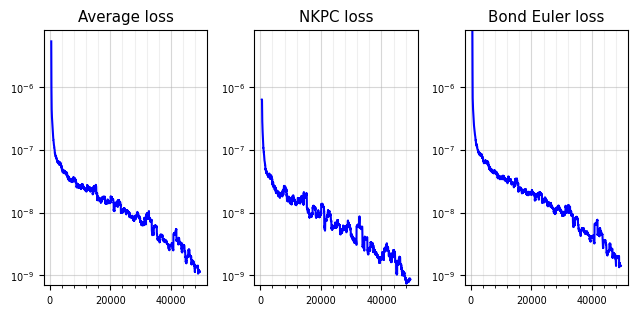

In [ ]:
fig_loss, _ = plot_loss(model.loss_dict, ma=1000)

In [ ]:
# Analytical policy function
def policy_analytical(state, par):
    # Calculate steady state
    kappa = ((1 - par.phi) * (1 - par.phi * par.beta) * (par.sigma + par.eta)) / par.phi
    omega = (1 + par.eta) / (par.sigma + par.eta)
    ss = Parameters({"kappa": kappa, "omega": omega})

    # Calculate policy
    X = (1 - par.beta * par.rho_a) * state.zeta / ((par.sigma * (1 - par.rho_a) + par.phiy) * (1 - par.beta * par.rho_a) + ss.kappa * (par.phipi - par.rho_a))
    Pi = ss.kappa * state.zeta / ((par.sigma * (1 - par.rho_a) + par.phiy) * (1 - par.beta * par.rho_a) + ss.kappa * (par.phipi - par.rho_a))

    return X, Pi

In [ ]:
def policy_over_par(model, shock_std=0.0, par=None, par_name="beta", n=100, analytical=False):
    par_range = model.range.get(par_name)
    lower_bound = par_range.support.lower_bound
    upper_bound = par_range.support.upper_bound
    grid = torch.linspace(lower_bound, upper_bound, n).view(-1, 1)

    if par is None:
        par = deepcopy(model.par)

    Pi_list = []
    X_list = []

    for g in grid:
        # Set parameter
        par.set(par_name, g)

        # Steady state
        ss = model.steady_state(par=par)

        # Set state
        sigma = par.sigma_a * par.sigma * (par.rho_a - 1) * ss.omega
        state = State({"zeta": torch.tensor([shock_std * sigma])})

        with torch.no_grad():
            if analytical:
                Pi, X = policy_analytical(state=state, par=par)
            else:
                Pi, X = model.policy(state=state, par=par)
            Pi_list.append(Pi)
            X_list.append(X)

        out = {"grid": grid, "X": torch.cat(X_list, dim=0), "Pi": torch.cat(Pi_list, dim=0)}

    return out

In [ ]:
def policy_over_par_list(model, shock_std=-1.0, par_list=None, n=100, analytical=False):
    if par_list is None:
        par_list = model.par.keys()

    out = {}
    for par_name in par_list:
        grid, X, Pi = policy_over_par(model, shock_std, par_name=par_name, n=n, analytical=analytical).values()
        out[par_name] = {"grid": grid, "X": X, "Pi": Pi}

    return out

### Figures 3 and 9 in the paper.
*Note that the figures may deviate from the one in the paper because some settings are not exactly the same as in the paper. We chose these adjustments to ensure a fast runtime in different computational environments.*

In [ ]:
def plot_par_list(model, shock_std=-1.0, policy="Pi", par_list=None, n=100, fig=None, ax=None):
    # Some constants
    n_cols = 2
    n_rows = 4
    y_space = 0.001
    if par_list is None:
        par_list = model.par.keys()

    # Create figure and axes if not provided
    if fig is None and ax is None:
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(10.0 / 1.55, 13 / 1.55))

    # Font size
    plt.rc("font", size=7)

    # Analytical and numerical solutions
    ana = policy_over_par_list(model, shock_std, par_list=par_list, n=n, analytical=True)
    num = policy_over_par_list(model, shock_std, par_list=par_list, n=n, analytical=False)

    # Add titles and ylabel strings
    if policy == "Pi":
        title = r"PF $\hat{\Pi}_t$ conditioned on "
    elif policy == "X":
        title = r"PF $\hat{X}_t$ conditioned on "

    par_latex = [r"$\beta$", r"$\sigma$", r"$\eta$", r"$\phi$", r"$\phi_{\Pi}$", r"$\phi_{Y}$", r"$\rho_A$", r"$\sigma_A$"]

    ylabel_list = [
        "Discount factor",
        "Relative risk aversion",
        "Inverse Frisch elasticity",
        "Price duration",
        "MP inflation response",
        "MP output response",
        "Persistence shock",
        "Standard deviation shock",
    ]

    for i, key in enumerate(par_list):
        row = i // n_cols
        col = i % n_cols
        ax[row, col].plot(num[key]["grid"], num[key][policy], label="Neural network", linewidth=1.5, color="blue")
        ax[row, col].plot(ana[key]["grid"], ana[key][policy], label="Analytical solution", linewidth=1.5, linestyle="dashed", color="red")
        ax[row, col].set_title(f"{title} {par_latex[i]}")
        ax[row, col].set_xlabel(f"{ylabel_list[i]} {par_latex[i]}")

        ymin = torch.min(ana[key][policy]).item()
        ymax = torch.max(ana[key][policy]).item()
        xmin = torch.min(ana[key]["grid"]).item()
        xmax = torch.max(ana[key]["grid"]).item()
        ax[row, col].set_ylim(bottom=ymin - y_space, top=ymax + y_space)
        ax[row, col].set_xlim(left=xmin, right=xmax)

        ax[row, col].tick_params(axis="both", which="major", labelsize=6)
        ax[row, col].tick_params(axis="both", which="minor", labelsize=6)

        # Add legend in the last subplot
        if i == len(par_list) - 1:
            ax[row, col].legend(loc="lower right")

    # Adjust layout
    fig.tight_layout()

    # Adjust style
    fig, ax = style_fig_ax(fig, ax, xminor=5, yminor=4)

    return fig, ax

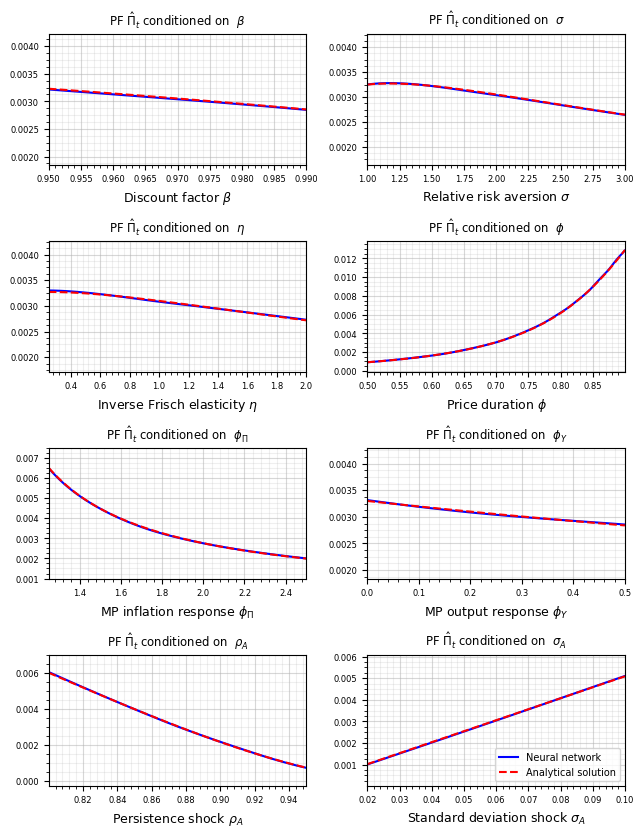

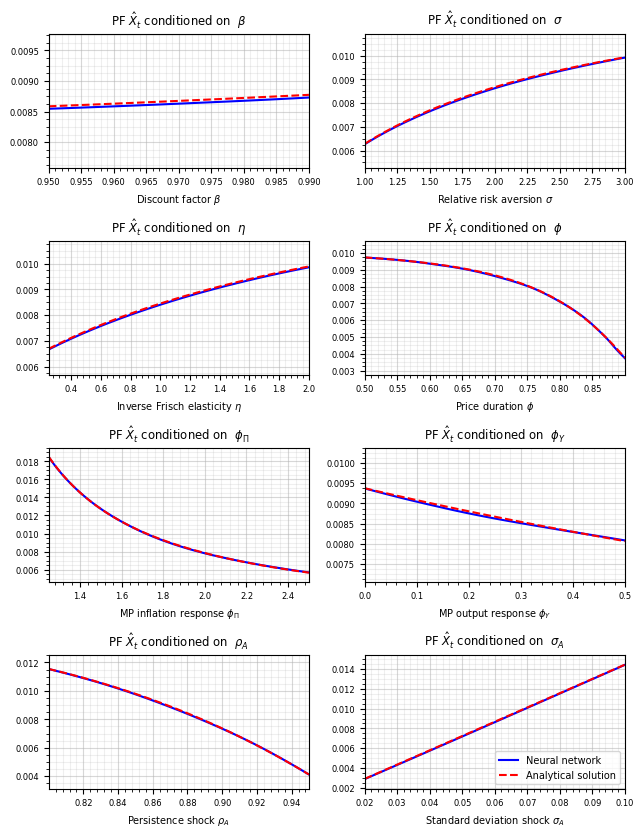

In [ ]:
fig_Pi_par_list, _ = plot_par_list(model, shock_std=-1.0, policy="Pi", par_list=None, n=100)
save_figure(fig_Pi_par_list, f"{directory}/solution_comparison_Pi")

fig_X_par_list, _ = plot_par_list(model, shock_std=-1.0, policy="X", par_list=None, n=100)
save_figure(fig_X_par_list, f"{directory}/solution_comparison_X")

## Neural network particle filter
Outline:
1. **Synthetic data** - simulate the model to generate synthetic data of length 1000. We will not use all of it, but only the first 100 observations, but it gives the flexibility to use longer time series.
2. **Synthetic data with measurement error** - add measurement error to the synthetic data.
3. **NN Particle filter** - defines the NN particle filter class that creates a dataset of parameter values with according log-likelihoods from using the particle filter (`filter_dataset`), sets up the NN particle filter (`make_network`), and trains it using the dataset (`train`). In addition there are some helper methods to save and load the model (`save`, `load`, `load_attributes`), and run the particle filter over a grid of parameter values (`filter_grid`).

### Synthetic data

In [ ]:
data = model.simulate(seed=1234, batch=1, burn=1000, steps=1000, device="cpu")

### Synthetic data with measurement error

In [ ]:
def covariance_matrix(data):
    R = torch.zeros((len(data), len(data)))
    for i, (key, value) in enumerate(data.items()):
        R[i, i] = value.var()
    return R


def add_measurement_error(data, error_share=0.1, seed=None):
    # Seed
    if seed is not None:
        torch.manual_seed(seed)

    # Error covariance matrix
    R = covariance_matrix(data) * error_share

    # Measurement error series
    me = {}
    for i, (key, value) in enumerate(data.items()):
        me[key] = torch.randn_like(value) * torch.sqrt(R[i, i])

    # Add measurement error to data
    data_me = {}
    for key, value in data.items():
        data_me[key] = value + me[key]

    return data_me, R


data_me, R = add_measurement_error(data, error_share=0.1, seed=1234)

### Particle filter

In [ ]:
class ParticleFilter:
    def __init__(self, model, data, R):
        self.model = model
        self.data = data
        self.S = len(data)
        self.R = R
        self.R_inv = torch.linalg.inv(R)
        self.R_det = torch.linalg.det(R)
        self.diagnostics = None
        self.dataset = None
        self.network = self.make_network()
        self.loss_dict = None

    def to(self, device):
        self.model.to(device)
        self.network.to(device)

    def save(self, path, name="pf"):
        # Create directory
        Path(path).mkdir(parents=True, exist_ok=True)

        # Save NKModel object
        self.to("cpu")
        with open(f"{path}/{name}.pkl", "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, path):
        # Load the object
        with open(path, "rb") as f:
            return pickle.load(f)

    def load_attributes(self, path):
        # Load attributes
        with open(path, "rb") as f:
            load = pickle.load(f)

        # Populate attributes
        self.__dict__.update(load.__dict__)

    @staticmethod
    def kitagawa(w_norm, P, aux=0.4532):
        device = w_norm.device
        cum_dist = torch.cumsum(w_norm, dim=-1)
        u = torch.arange(aux, P, step=1.0, device=device) / P
        idx = torch.searchsorted(cum_dist, u, right=False)
        return idx

    @staticmethod
    def log_prob(error_tensor, R_inv, R_det):
        S = error_tensor.size(0)
        log_prob = -0.5 * (S * math.log(2.0 * math.pi) + torch.log(R_det) + torch.sum(error_tensor * torch.mm(R_inv, error_tensor), dim=0))
        return log_prob

    def filter(self, P, burn=100, sim=100, par=None, device="cpu"):
        if par is None:
            par = deepcopy(self.model.par)
        else:
            par = deepcopy(par)

        # Number of series
        S = self.S

        # Move to device
        par.to(device)
        self.model.to(device)

        # Initialize
        self.model.par_draw = par.expand((P, 1))
        self.model.state = self.model.initialize_state(batch=P, device=device)
        self.model.ss = self.model.steady_state()

        # Burn
        self.model.steps(batch=P, device=device, steps=burn)

        # Filter
        filtered_model_out = {key: [] for key in data.keys()}
        log_likelihood = torch.empty(sim)
        for t in range(sim):
            model_out = self.model.sim_step()

            # Error
            error = torch.empty((S, P), device="cpu")
            for i, (key, value) in enumerate(model_out.items()):
                error[i, :] = value.squeeze(-1).to("cpu") - data[key][..., t]

            # Log probabilities
            log_prob = self.log_prob(error, self.R_inv, self.R_det)

            # Weights
            w = torch.exp(log_prob)

            # Log likelihood
            log_likelihood[t] = torch.log(torch.mean(w))

            # Normalize weights
            w_norm = w / torch.sum(w)

            # Resample
            idx = self.kitagawa(w_norm, P)

            # Resample states
            self.model.state.update({key: value[idx, ...] for key, value in self.model.state.items()})

            # Update step
            self.model.steps(batch=P, steps=1, device=device)

            # Filter model output
            for key, value in model_out.items():
                filtered_model_out[key].append(torch.mean(value[idx, ...], dim=0))

        # Stack filtered data
        for key, value in filtered_model_out.items():
            filtered_model_out[key] = torch.stack(value, dim=-1)

        return torch.sum(log_likelihood), filtered_model_out

    def filter_grid(self, par_name, n=25, sim=100, par=None, P=1000, surrogate=False, random_draws=False):
        if par is None:
            par = deepcopy(self.model.par)

        lower_bound = self.model.range.get(par_name).support.lower_bound
        upper_bound = self.model.range.get(par_name).support.upper_bound

        if random_draws:
            grid = lower_bound + (upper_bound - lower_bound) * torch.rand(n, 1)
        else:
            grid = torch.linspace(lower_bound, upper_bound, n).view(-1, 1)

        log_likelihood = torch.empty(n)
        for i in trange(n):
            par.set(par_name, grid[i])

            if surrogate is False:
                log_likelihood[i], _ = self.filter(P, par=par, sim=sim)
            elif surrogate is True:
                with torch.no_grad():
                    log_likelihood[i] = self.network(par.cat()).item()

        return grid, log_likelihood

    def filter_dataset(self, par_names=None, N=1000, par=None, P=1000, sim=100, device="cpu", sobol=False):
        # Make a copy of par
        if par is None:
            par = deepcopy(self.model.par)

        # Parameters that vary in the dataset
        if par_names is None:
            par_names = par.keys()

        # Create Sobol draws if necessary
        if sobol:
            sampler = torch.quasirandom.SobolEngine(
                len(par_names),
            )
            sobol_draws = sampler.draw(N).squeeze(-2)

        par_list = []
        log_likelihood_list = []
        for n in trange(N):
            # Draw parameters
            par_draw = {}
            idx = 0
            for key in par.keys():
                if key in par_names:
                    if sobol:
                        low = self.model.range.get(key).support.lower_bound
                        high = self.model.range.get(key).support.upper_bound
                        par_draw[key] = low + (high - low) * sobol_draws[n, idx].view(1)
                        idx += 1
                    else:
                        par_draw[key] = self.model.range.get(key).sample((1,))
                else:
                    par_draw[key] = par.get(key)

            # Convert to Parameters object
            par_draw = Parameters(par_draw)

            # Calculate likelihood
            log_likelihood, _ = self.filter(P, par=par_draw, sim=sim, device=device)

            # Store
            par_list.append(par_draw.cat())
            log_likelihood_list.append(log_likelihood)

        # Create dataset by stacking par_list together and log_likelihood_list together
        par_tensor = torch.stack(par_list, dim=0)
        log_likelihood_tensor = torch.stack(log_likelihood_list, dim=0)

        self.dataset = {"par": par_tensor, "log_likelihood": log_likelihood_tensor}

    def make_network(self, N_inputs=None, hidden=64, layers=3, activation=torch.nn.CELU(), normalize=True):
        if N_inputs is None:
            N_inputs = len(self.model.par)

        N_outputs = 1

        layer_list = []

        # Normalization layer
        if normalize:
            lower_bound = self.model.range.low_tensor()
            upper_bound = self.model.range.high_tensor()
            layer_list.append(NormalizeLayer(lower_bound, upper_bound))

        # First layer
        layer_list.append(torch.nn.Linear(N_inputs, hidden))
        layer_list.append(activation)

        # Middle layers
        for _ in range(1, layers):
            layer_list.append(torch.nn.Linear(hidden, hidden))
            layer_list.append(activation)

        # Last layer
        layer_list.append(torch.nn.Linear(hidden, N_outputs))

        # Build the network
        self.network = torch.nn.Sequential(*layer_list)

    def train(self, batch=64, epochs=10000, device="cpu", lr=1e-3, eta_min=1e-6, validation_share=0.2, print_after=1000):
        # Create optimizer and scheduler
        optimizer = torch.optim.AdamW(self.network.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

        # Randomly shuffle the dataset
        idx = torch.randperm(self.dataset["par"].size(0))
        self.dataset["par"] = self.dataset["par"][idx, ...]
        self.dataset["log_likelihood"] = self.dataset["log_likelihood"][idx, ...]

        # Split dataset into training and validation samples
        N = self.dataset["par"].size(0)
        N_train = int(N * (1 - validation_share))
        dataset_train = torch.utils.data.TensorDataset(self.dataset["par"][:N_train, ...], self.dataset["log_likelihood"][:N_train, ...].unsqueeze(-1))
        dataset_validation = torch.utils.data.TensorDataset(self.dataset["par"][N_train:, ...], self.dataset["log_likelihood"][N_train:, ...].unsqueeze(-1))

        # Create dataloader for training and validation
        dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch, shuffle=True)
        dataloader_validation = torch.utils.data.DataLoader(dataset_validation, batch_size=batch, shuffle=True)

        # Set the network to train mode
        self.network.train()
        self.network.to(device)

        # Progress bar
        pbar = trange(epochs)

        # Dictionary for loss
        self.loss_dict = {"iteration": [], "training_loss": [], "validation_loss": []}

        # Training loop over epochs
        for i in pbar:
            for x, y in dataloader_train:
                # Move to device
                x = x.to(device)
                y = y.to(device)

                # Forward pass
                y_hat = self.network(x)

                # Loss
                loss = torch.nn.functional.mse_loss(y_hat, y)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(self.network.parameters(), 1.0)
                optimizer.step()

            # Update learning rate
            scheduler.step()

            # Print training and validation loss in the progress bar after x epochs
            if i % print_after == 0:
                # Training loss
                with torch.no_grad():
                    training_loss = 0.0
                    for x, y in dataloader_train:
                        x = x.to(device)
                        y = y.to(device)
                        y_hat = self.network(x)
                        training_loss += torch.nn.functional.mse_loss(y_hat, y, reduction="sum").item()
                    training_loss = training_loss / len(dataset_train)

                # Validation loss
                with torch.no_grad():
                    validation_loss = 0.0
                    for x, y in dataloader_validation:
                        x = x.to(device)
                        y = y.to(device)
                        y_hat = self.network(x)
                        validation_loss += torch.nn.functional.mse_loss(y_hat, y, reduction="sum").item()
                    validation_loss = validation_loss / len(dataset_validation)

                # Record training and validation loss in the dictionary
                self.loss_dict["iteration"].append(i)
                self.loss_dict["training_loss"].append(training_loss)
                self.loss_dict["validation_loss"].append(validation_loss)

                # Update progress bar
                pbar.set_postfix({"lr:": scheduler.get_last_lr()[0], "training": training_loss, "validation": validation_loss})

        # Set network to evaluation mode
        self.network.eval()

In [ ]:
# Create NN particle filter object
pf = ParticleFilter(model, data_me, R=R)

In [ ]:
# Generate training data
if not load_pf:
    pf.filter_dataset(N=10000, P=100, sim=100, device="cpu", sobol=True)

In [ ]:
# Create and initialize the NN
pf.make_network(hidden=128, layers=4, normalize=True)

In [ ]:
# Train the NN particle filter
if not load_pf:
    pf.train(batch=100, epochs=5000, device="cpu", lr=1e-3, eta_min=1e-8, print_after=10)

In [ ]:
if not load_pf:
    pf.save(path="save", name="particle_filter")

In [ ]:
if load_pf:
    pf = ParticleFilter.load("save/particle_filter.pkl")

## Figures illustrating the NN particle filter

###  Figure 4 in the paper.
*Note that the figure may deviate from the one in the paper because some settings are not exactly the same as in the paper. We chose these adjustments to ensure a fast runtime in different computational environments.*

In [ ]:
def plot_loss_likeli(loss_dict, ylim=None, ma=1, legend=None):
    # Create figure with 1 row and 2 columns for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10.0 / 1.55, 5.0 / 1.55))

    # Font size
    plt.rc("font", size=8)

    # Calculate moving average over loss
    tmp_dict = {key: np.convolve(value, np.ones(ma), "valid") / ma for key, value in loss_dict.items()}

    # Titles for each plot
    titles = ["Total loss - Training Sample", "Total loss - Validation Sample"]

    # Data for each plot
    data = [(tmp_dict["iteration"], tmp_dict["training_loss"], "blue"), (tmp_dict["iteration"], tmp_dict["validation_loss"], "red")]

    # Loop over each subplot
    for ax, title, (x, y, color) in zip(axes, titles, data):
        ax.plot(x, y, label=legend, color=color)
        ax.set_title(title)
        ax.set_yscale("log")
        ax.set_ylim(ylim)
        ax.set_ylabel("Mean squared error")
        ax.set_xlabel("Epoch")
        ax.minorticks_on()
        ax.grid(which="major", alpha=0.5)
        ax.grid(which="minor", alpha=0.2)
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(NullLocator())

        ax.tick_params(axis="both", which="major", labelsize=7)
        ax.tick_params(axis="both", which="minor", labelsize=7)

    # Adjust layout
    plt.tight_layout()

    # Adjust style
    fig, axes = style_fig_ax(fig, axes)

    return fig, ax

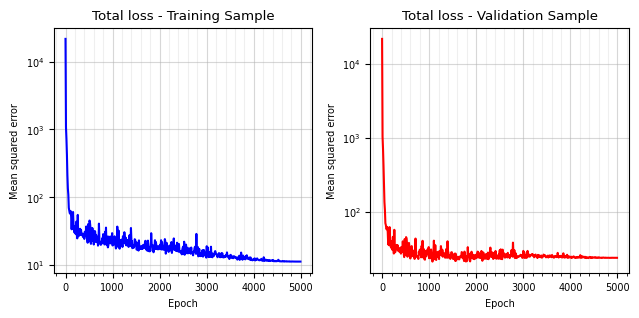

In [ ]:
fig_avg_loss, _ = plot_loss_likeli(pf.loss_dict, ma=1)

In [ ]:
save_figure(fig_avg_loss, f"{directory}/pf_loss")

###  Figure 5 in the paper.
*Note that the figure may deviate from the one in the paper because some settings are not exactly the same as in the paper. We chose these adjustments to ensure a fast runtime in different computational environments.*

In [ ]:
def plot_likelihood_single(pf, par_name="sigma", N_1=50, N_2=250, P_1=2000, P_2=100, sim=100, fig=None, ax=None, full=False, random=True):
    grid, ll_grid_surrogate = pf.filter_grid(par_name=par_name, n=N_1, surrogate=True)
    if full:
        grid, ll_grid_full = pf.filter_grid(par_name=par_name, n=N_1, P=P_1, sim=sim)
    if random:
        grid_random, ll_grid_random = pf.filter_grid(par_name=par_name, n=N_2, P=P_2, sim=sim, random_draws=True)

    # Create figure and axes if not provided
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10.0 / 1.55, 5.0 / 1.55))

    # Plot lines
    ax.plot(grid, ll_grid_surrogate, color="blue", label="Neural Network")

    if full:
        ax.plot(grid, ll_grid_full, linestyle="dashed", color="red", label=f"Particle Filter, {P_1} particles")
    
    if random:
        ax.scatter(grid_random, ll_grid_random, marker="o", s=15, alpha=0.75, color="#dd8453", label=f"Particle Filter, {P_2} particles", zorder=1)

    # Plot vertical line
    ax.axvline(x=NK_par[par_name], color="black", linestyle="dotted", label="True value")

    # Set title, labels, legend, and grid
    ax.legend(loc="lower right")
    ax.set_title(rf"Log Likelihood $\log \mathcal{{L}}_{{\bar{{\Theta}}}}$ conditioned on $\{par_name}$")
    ax.set_ylabel(r"Log Likelihood")
    ax.set_xlabel(rf"Relative risk aversion $\{par_name}$")

    # Set y-axis limits
    y_min = min(min(ll_grid_surrogate), min(ll_grid_random)) - 25
    y_max = max(max(ll_grid_surrogate), max(ll_grid_random)) + 25
    ax.set_ylim([y_min, y_max])

    # Set y-axis limits
    x_min = min(grid)
    x_max = max(grid)
    ax.set_xlim([x_min, x_max])

    # Adjust layout
    plt.tight_layout()

    # Adjust style
    fig, ax = style_fig_ax(fig, ax)

    return fig, ax

100%|██████████| 250/250 [00:09<00:00, 27.66it/s]


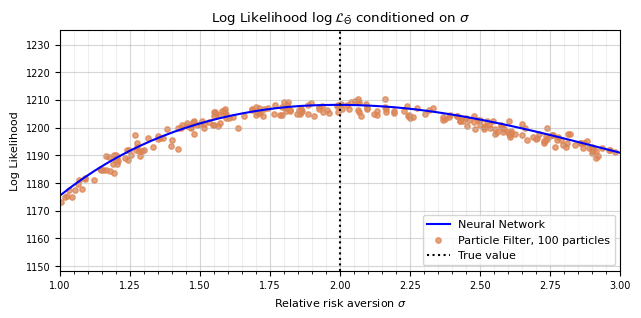

In [ ]:
par_name = "sigma"
fig_likelihood_single, _ = plot_likelihood_single(pf, par_name, sim=100)

In [ ]:
save_figure(fig_likelihood_single, f"{directory}/NN_likelihood_{par_name}")

In [ ]:
def compute_results(pf, parameter, n=50, n_random=200, P_1=100, P_2=100, sim=100, full=False, random=True):
    result = {}
    grid, ll_grid_surrogate = pf.filter_grid(par_name=parameter, n=n, surrogate=True)
    result["grid"] = grid
    result["ll_grid_surrogate"] = ll_grid_surrogate
    if full:
        grid, ll_grid_full = pf.filter_grid(par_name=parameter, n=n, P=P_1, sim=sim)
        result["ll_grid_full"] = ll_grid_full
    if random:
        grid_random, ll_grid_random = pf.filter_grid(par_name=parameter, n=n_random, P=P_2, sim=sim, random_draws=True)
        result["grid_random"] = grid_random
        result["ll_grid_random"] = ll_grid_random

    return result

# Store results in a dictionary
results = {}
for par_name in NK_par.keys():
    results[par_name] = compute_results(pf, par_name, sim=100)

100%|██████████| 200/200 [00:07<00:00, 28.45it/s]


###  Figure 10 in the paper.
*Note that the figure may deviate from the one in the paper because some settings are not exactly the same as in the paper. We chose these adjustments to ensure a fast runtime in different computational environments.*

In [ ]:
def plot_likelihood_parameters(results, fig=None, ax=None):
    # Create figure and axes if not provided
    if fig is None and ax is None:
        fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10 / 1.55, 13 / 1.55))

    # Font size
    plt.rc("font", size=7)

    title = r"Log Likelihood $\log \mathcal{L}_{\bar{\Theta}}$ conditioned on "
    par_latex = [r"$\beta$", r"$\sigma$", r"$\eta$", r"$\phi$", r"$\phi_{\Pi}$", r"$\phi_{Y}$", r"$\rho_A$", r"$\sigma_A$"]

    ylabel_list = [
        "Discount factor",
        "Relative risk aversion",
        "Inverse Frisch elasticity",
        "Price duration",
        "MP inflation response",
        "MP output response",
        "Persistence shock",
        "Standard deviation shock",
    ]

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Plot each parameter in a subplot
    for i, (par_name, result) in enumerate(results.items()):
        ax = axes[i]  # Use the specific Axes object
        ax.plot(result["grid"], result["ll_grid_surrogate"], color="blue", label="Neural Network")
        
        if results[par_name].get("ll_grid_full") is not None:
            ax.plot(result["grid"], result["ll_grid_full"], color="red", linestyle="dashed", label="Particle Filter")
        
        if results[par_name].get("ll_grid_random") is not None:
            ax.scatter(result["grid_random"], result["ll_grid_random"], marker="o", s=15, alpha=0.5, color="#dd8453", label="Random Draws", zorder=1)
        
        ax.axvline(x=NK_par[par_name], color="black", linestyle="dotted", label="True value")

        # Set y-axis limits
        y_min = min(min(result["ll_grid_surrogate"]), min(result["ll_grid_surrogate"])) - 50
        y_max = max(max(result["ll_grid_surrogate"]), max(result["ll_grid_surrogate"])) + 50
        ax.set_ylim([y_min, y_max])

        # Set x-axis tight
        ax.autoscale(enable=True, axis="x", tight=True)

        # Set title, labels, and legend
        ax.set_title(f"{title} {par_latex[i]}")
        ax.set_xlabel(f"{ylabel_list[i]} {par_latex[i]}")
        ax.minorticks_on()
        ax.grid(which="major", alpha=0.5)
        ax.grid(which="minor", alpha=0.2)
        if i == len(results.items()) - 1:
            ax.legend(loc="lower right")

    # Adjust layout
    plt.tight_layout()

    # Adjust style
    fig, axes = style_fig_ax(fig, axes)

    return fig, ax

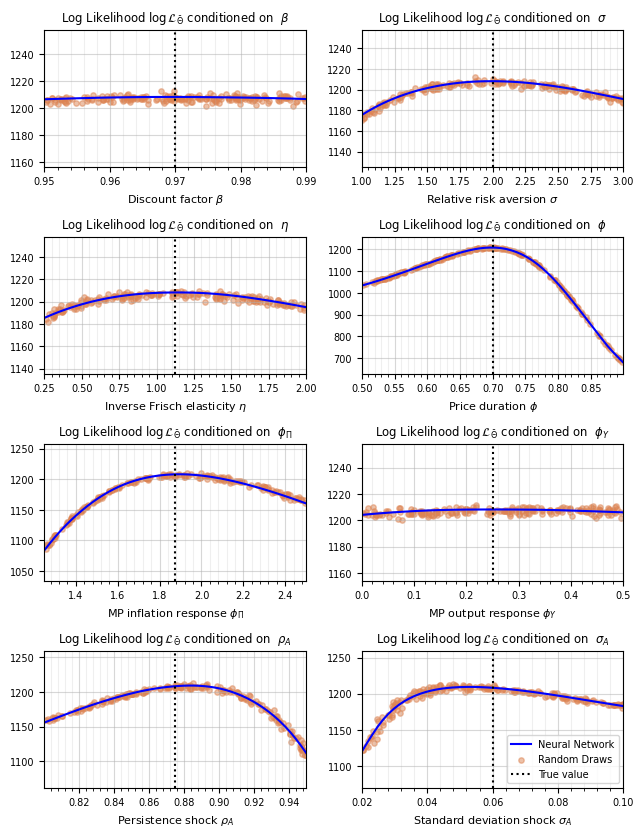

In [ ]:
fig_likelihood_parameters, _ = plot_likelihood_parameters(results)

In [ ]:
save_figure(fig_likelihood_parameters, f"{directory}/NN_likelihood_all")